# A First Neural Network Example

In this demo, you will learn:
* How to construct and train a simple neural network with one hidden layer using the `keras` package
* How to get the weights and intermediate layer outputs of a `keras` network after training
* How to visualize the weights 

To illustrate the concepts, we consider a simple 2D classification problem on completely synthetic data. Using synthetic data will allow us to visualize the network more easily.  We will then look at real data in later demos  

## Loading Keras

The `keras` package provides a powerful and simple platform for building and fitting neural networks.  To run `keras`, you must first install a so-called deep learning *backend*.  We suggest using [Tensorflow](https://www.tensorflow.org/install/), but `keras` can be run with other common deep learning packages including CNTK or Theano.  `Keras` is then built as a wrapper on top of these packages.  Building most neural networks in `keras` is generally much simpler than in raw Tensorflow and is perfect for getting started.  Later, if you want more flexibility, you can learn how to build models in Tensorflow directly.

After you have installed Tensorflow (or, whatever backend you are using), you will need to install keras.  This can be done via:

    pip install keras
    
at the command window.  You should then be able to load the package.

In [4]:
import keras

Using TensorFlow backend.


ImportError: Traceback (most recent call last):
  File "C:\Users\matta_000\AppData\Local\Programs\Python\Python36\lib\site-packages\tensorflow\python\pywrap_tensorflow.py", line 58, in <module>
    from tensorflow.python.pywrap_tensorflow_internal import *
  File "C:\Users\matta_000\AppData\Local\Programs\Python\Python36\lib\site-packages\tensorflow\python\pywrap_tensorflow_internal.py", line 28, in <module>
    _pywrap_tensorflow_internal = swig_import_helper()
  File "C:\Users\matta_000\AppData\Local\Programs\Python\Python36\lib\site-packages\tensorflow\python\pywrap_tensorflow_internal.py", line 24, in swig_import_helper
    _mod = imp.load_module('_pywrap_tensorflow_internal', fp, pathname, description)
  File "C:\Users\matta_000\AppData\Local\Programs\Python\Python36\lib\imp.py", line 242, in load_module
    return load_dynamic(name, filename, file)
  File "C:\Users\matta_000\AppData\Local\Programs\Python\Python36\lib\imp.py", line 342, in load_dynamic
    return _load(spec)
ImportError: DLL load failed: The specified module could not be found.


Failed to load the native TensorFlow runtime.

See https://www.tensorflow.org/install/errors

for some common reasons and solutions.  Include the entire stack trace
above this error message when asking for help.

We also load some other common packages.

In [5]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

## Synthetic Data 

To illustrate the neural network we generate data with some rule that will create an interesting classification region. 

In [6]:
nsamp = 400   # number of samples to generate
nx = 2        # number of dimensions of each sample

# The features are generated uniformly on the square [0,1] x [0,1]
X = np.random.uniform(0,1,(nsamp,nx))

# The class of each sample is determined by some Gaussian.  The particular function is not important.
rsq = (X[:,0]-0.5)**2 + (X[:,1]-0.5)**2
z = 10*(np.exp(-8*rsq)-0.5)
py = 1/(1+np.exp(-z))
u = np.random.uniform(0,1,nsamp)
y = (u < py).astype(int)

We create a scatter plot of the data.  You can see that it is not linearly seperable.  

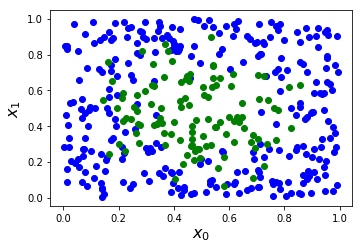

In [7]:
I0 = np.where(y==0)[0]
I1 = np.where(y==1)[0]
plt.plot(X[I0,0], X[I0,1], 'bo')
plt.plot(X[I1,0], X[I1,1], 'go')
plt.xlabel('$x_0$', fontsize=16)
plt.ylabel('$x_1$', fontsize=16)
plt.subplots_adjust(bottom=0.2, left=0.2)

## Creating a Simple Neural Network.

We see that the above points are not linearly separable.  We will see if we can build a simple neural network classifier to find a good decision region.  We first import some key sub-packages from `keras`.

In [8]:
from keras.models import Model, Sequential
from keras.layers import Dense, Activation

Using TensorFlow backend.


ImportError: Traceback (most recent call last):
  File "C:\Users\matta_000\AppData\Local\Programs\Python\Python36\lib\site-packages\tensorflow\python\pywrap_tensorflow.py", line 58, in <module>
    from tensorflow.python.pywrap_tensorflow_internal import *
  File "C:\Users\matta_000\AppData\Local\Programs\Python\Python36\lib\site-packages\tensorflow\python\pywrap_tensorflow_internal.py", line 28, in <module>
    _pywrap_tensorflow_internal = swig_import_helper()
  File "C:\Users\matta_000\AppData\Local\Programs\Python\Python36\lib\site-packages\tensorflow\python\pywrap_tensorflow_internal.py", line 24, in swig_import_helper
    _mod = imp.load_module('_pywrap_tensorflow_internal', fp, pathname, description)
  File "C:\Users\matta_000\AppData\Local\Programs\Python\Python36\lib\imp.py", line 242, in load_module
    return load_dynamic(name, filename, file)
  File "C:\Users\matta_000\AppData\Local\Programs\Python\Python36\lib\imp.py", line 342, in load_dynamic
    return _load(spec)
ImportError: DLL load failed: The specified module could not be found.


Failed to load the native TensorFlow runtime.

See https://www.tensorflow.org/install/errors

for some common reasons and solutions.  Include the entire stack trace
above this error message when asking for help.

Next, we clear the session.  This is not strictly necessary, but it is good practice as it clears any model layers that you have built before.  Otherwise, they keep hanging around.

In [6]:
import keras.backend as K
K.clear_session()

Now we create a very simple network with one hidden layer with `nh=4` hidden units.  There is `nout=1` output unit corresponding to the estimated class label.

In [7]:
nin = nx  # dimension of input data
nh = 4    # number of hidden units
nout = 1  # number of outputs = 1 since this is binary
model = Sequential()
model.add(Dense(nh, input_shape=(nx,), activation='sigmoid', name='hidden'))
model.add(Dense(1, activation='sigmoid', name='output'))

Keras provides a nice command for visualizing the layers.  

In [8]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
hidden (Dense)               (None, 4)                 12        
_________________________________________________________________
output (Dense)               (None, 1)                 5         
Total params: 17
Trainable params: 17
Non-trainable params: 0
_________________________________________________________________


## Training the Network

To train the network, we have to select an optimizer and a loss function.  Since this is a binary classification problem, we select the `binary_crossentropy` loss.  For the optimizer, `adam` tends to works well over a wide range of problems and is a good starting point.  We also set the `metrics` that we wish to track during the optimization.  In this case, we select `accuracy` on the training set.

In [9]:
from keras import optimizers

opt = optimizers.Adam(lr=0.01, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)
model.compile(optimizer=opt,
              loss='binary_crossentropy',
              metrics=['accuracy'])

Keras provides a simple method `fit` to run the optimization.  You simply specify the number of epochs and the batch size, both discussed in class.

In [10]:
model.fit(X, y, epochs=10, batch_size=100)

Epoch 1/10
400/400 [==============================] - 0s 464us/step - loss: 0.6881 - acc: 0.5325
Epoch 2/10
400/400 [==============================] - 0s 19us/step - loss: 0.6524 - acc: 0.7550
Epoch 3/10
400/400 [==============================] - 0s 22us/step - loss: 0.6226 - acc: 0.7600
Epoch 4/10
400/400 [==============================] - 0s 21us/step - loss: 0.5984 - acc: 0.7600
Epoch 5/10
400/400 [==============================] - 0s 22us/step - loss: 0.5824 - acc: 0.7600
Epoch 6/10
400/400 [==============================] - 0s 23us/step - loss: 0.5693 - acc: 0.7600
Epoch 7/10
400/400 [==============================] - 0s 34us/step - loss: 0.5605 - acc: 0.7600
Epoch 8/10
400/400 [==============================] - 0s 33us/step - loss: 0.5560 - acc: 0.7600
Epoch 9/10
400/400 [==============================] - 0s 27us/step - loss: 0.5525 - acc: 0.7600
Epoch 10/10
400/400 [==============================] - 0s 24us/step - loss: 0.5515 - acc: 0.7600


Unfortunately, for this problem, we need a large number of epochs -- around 1000.  We don't want to print out the progress on each epoch.  So, the code below disables the print outs by setting `verbose=0`.  Then, we run the optimization in 20 iterations with 50 epochs per iteration -- a total of 1000 epochs.  In each iteration, we use the `evaluate` method to get the loss function and accuracy and print that out manually.

In [11]:
nit = 20   # number of training iterations
nepoch_per_it = 50  # number of epochs per iterations

# Loss, accuracy and epoch per iteration
loss = np.zeros(nit)
acc = np.zeros(nit)
epoch_it = np.zeros(nit)

# Main iteration loop
for it in range(nit):
    
    # Continue the fit of the model
    init_epoch = it*nepoch_per_it
    model.fit(X, y, epochs=nepoch_per_it, batch_size=100, verbose=0)
    
    # Measure the loss and accuracy on the training data
    lossi, acci = model.evaluate(X,y, verbose=0)
    epochi = (it+1)*nepoch_per_it
    epoch_it[it] = epochi
    loss[it] = lossi
    acc[it] = acci
    print("epoch=%4d loss=%12.4e acc=%7.5f" % (epochi,lossi,acci))

epoch=  50 loss=  5.5065e-01 acc=0.76000
epoch= 100 loss=  5.5043e-01 acc=0.76000
epoch= 150 loss=  5.5032e-01 acc=0.76000
epoch= 200 loss=  5.5019e-01 acc=0.76000
epoch= 250 loss=  5.5009e-01 acc=0.76000
epoch= 300 loss=  5.5004e-01 acc=0.76000
epoch= 350 loss=  5.4989e-01 acc=0.76000
epoch= 400 loss=  5.4985e-01 acc=0.76000
epoch= 450 loss=  5.4969e-01 acc=0.76000
epoch= 500 loss=  5.4957e-01 acc=0.76000
epoch= 550 loss=  5.4943e-01 acc=0.76000
epoch= 600 loss=  5.4915e-01 acc=0.76000
epoch= 650 loss=  5.4833e-01 acc=0.76000
epoch= 700 loss=  5.4437e-01 acc=0.76000
epoch= 750 loss=  5.3389e-01 acc=0.76000
epoch= 800 loss=  5.1808e-01 acc=0.76000
epoch= 850 loss=  5.0314e-01 acc=0.76000
epoch= 900 loss=  4.8785e-01 acc=0.76000
epoch= 950 loss=  4.5170e-01 acc=0.76000
epoch=1000 loss=  3.9156e-01 acc=0.82000


We can now plot the loss function and accuracy as a function of the epoch number.  

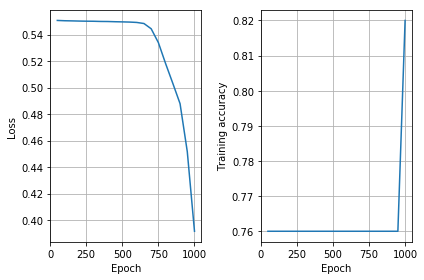

In [12]:
epoch_it = np.arange(1,nit+1)*nepoch_per_it
plt.subplot(1,2,1)
plt.plot(epoch_it, loss)
plt.grid()
plt.xlabel('Epoch')
plt.ylabel('Loss')

plt.subplot(1,2,2)
plt.plot(epoch_it, acc)
plt.grid()
plt.xlabel('Epoch')
plt.ylabel('Training accuracy')
plt.tight_layout()
plt.show()

Instead of manually measuring the loss and accuracy, we can pass a *callback* function.  This function is automatically called at each batch end.  We can then periodically print the value of the loss and accuracy.

In [13]:
class PeriodicPrintLoss(keras.callbacks.Callback):
    def __init__(self, prt_period=100):
        self.prt_period = prt_period
        
    def on_train_begin(self, logs={}):
        self.losses = []
        self.step = 0

    def on_batch_end(self, batch, logs={}):
        # Record the loss
        loss = logs.get('loss')
        self.losses.append(loss)
        
        # Print the loss periodically
        if (self.step % self.prt_period == 0):
            print('step=%6d loss=%12.4e' % (self.step, loss))
        self.step += 1
        
# Compute print period in steps 
batch_size = 100
prt_period = nepoch_per_it*int(nsamp/batch_size)

# Create the callback 
loss_cb = PeriodicPrintLoss(prt_period=prt_period)

# Run the fit with the callback
model.fit(X, y, epochs=200, batch_size=batch_size, verbose=0, callbacks=[loss_cb])

step=     0 loss=  4.4693e-01
step=   200 loss=  3.4394e-01
step=   400 loss=  2.6311e-01
step=   600 loss=  3.5927e-01


## Visualizing Decision Regions

To see how classification rule our neural network learned, we can plot the predicted class probability as a function of $(x_0,x_1)$.  To do this, we create an input matrix `Xplot` with entries that vary over $[0,1] \times [0,1]$.  We feed that into the trained network and see what the probility $P(y=1|x)$ is for each sample.  Then, we plot this like an image.

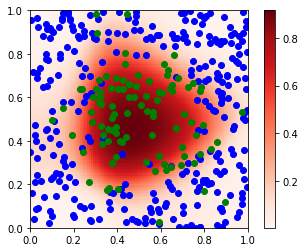

In [14]:
# Limits to plot the response.
xmin = [0,0]
xmax = [1,1]

# Use meshgrid to create the 2D input
nplot = 100
x0plot = np.linspace(xmin[0],xmax[1],nplot)
x1plot = np.linspace(xmin[0],xmax[1],nplot)
x0mat, x1mat = np.meshgrid(x0plot,x1plot)
Xplot = np.column_stack([x0mat.ravel(), x1mat.ravel()])

# Compute the output 
yplot = model.predict(Xplot)
yplot_mat = yplot[:,0].reshape((nplot, nplot))

# Plot the recovered region
plt.imshow(np.flipud(yplot_mat), extent=[xmin[0],xmax[0],xmin[0],xmax[1]], cmap=plt.cm.Reds)
plt.colorbar()

# Overlay the samples
I0 = np.where(y==0)[0]
I1 = np.where(y==1)[0]
plt.plot(X[I0,0], X[I0,1], 'bo')
plt.plot(X[I1,0], X[I1,1], 'go')

We see that the neural network is able to learn a nonlinear classification region matching the training data points.  To understand how this nonlinear region is realized it is useful to plot the response in the each of the hidden units.  To extract the output of an intermediate layer, we create a new model, `model1` with the outputs set to the hidden layer outputs and then run the `predict` command on that model.

Each of the hidden units produces one linear decision region.  The final nonlinear region is then formed by taking a weighted combination of these regions.

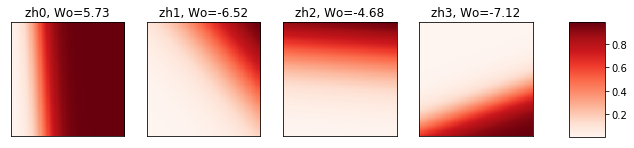

In [15]:
# Get the response in the hidden units 
layer_hid = model.get_layer('hidden')
model1 = Model(inputs=model.input,
               outputs=layer_hid.output)
zhid_plot = model1.predict(Xplot)
zhid_plot = zhid_plot.reshape((nplot,nplot,nh))

# Get the weights in the output layer
layer_out = model.get_layer('output')
Wo, bo = layer_out.get_weights()

fig = plt.figure(figsize=(10, 4))

for i in range(nh):

    plt.subplot(1,nh,i+1)
    zhid_ploti = np.flipud(zhid_plot[:,:,i])
    im = plt.imshow(zhid_ploti, extent=[xmin[0],xmax[0],xmin[0],xmax[1]], cmap=plt.cm.Reds)
    plt.xticks([])
    plt.yticks([])
    plt.title('zh{0:d}, Wo={1:4.2f}'.format(i,Wo[i,0]))
  
fig.subplots_adjust(right=0.85)
cbar_ax = fig.add_axes([0.9, 0.30, 0.05, 0.4])
fig.colorbar(im, cax=cbar_ax)

## Let us print the model parameters. 

First we print the entire model weights

In [22]:
g=model.get_weights()
print('Model weights')
print(g)

Model weights
[array([[ 14.33087158,   4.71652603,   0.44386455,   3.8302207 ],
       [  0.93531823,   4.01757574,   5.77826166, -10.8145647 ]], dtype=float32), array([-4.2243948 , -6.34534693, -4.64211845,  0.52410114], dtype=float32), array([[ 5.73100042],
       [-6.52343607],
       [-4.68132448],
       [-7.11747265]], dtype=float32), array([-1.29932046], dtype=float32)]


Now we print individual layer weights

In [23]:
layer_hid = model.get_layer('hidden')
Wh, bh = layer_hid.get_weights()
print('Wh=')
print(Wh)
print('bh=')
print(bh)

layer_out = model.get_layer('output')
Wo, bo = layer_out.get_weights()
print('Wo=')
print(Wo)
print('bo=')
print(bo)


Wh=
[[ 14.33087158   4.71652603   0.44386455   3.8302207 ]
 [  0.93531823   4.01757574   5.77826166 -10.8145647 ]]
bh=
[-4.2243948  -6.34534693 -4.64211845  0.52410114]
Wo=
[[ 5.73100042]
 [-6.52343607]
 [-4.68132448]
 [-7.11747265]]
bo=
[-1.29932046]


Note that the first hidden node corresponds to a separating line of 14.33 x_1 + 0.94 x_2 - 4.22 =0.